<a href="https://colab.research.google.com/github/imabari/covid19-data/blob/master/ibaraki/ibaraki_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!add-apt-repository ppa:alex-p/tesseract-ocr -y
!apt update
!apt install tesseract-ocr
!apt install libtesseract-dev
!tesseract -v

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://ppa.launchpad.net/alex-p/tesseract-ocr/ubuntu bionic InRelease [15.4 kB]
Get:12 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 http://security.ubuntu.com/ubuntu bionic-security/main amd64 P

In [2]:
!apt install tesseract-ocr-jpn  tesseract-ocr-jpn-vert
!apt install tesseract-ocr-script-jpan tesseract-ocr-script-jpan-vert
!tesseract --list-langs
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tesseract-ocr-jpn tesseract-ocr-jpn-vert
0 upgraded, 2 newly installed, 0 to remove and 23 not upgraded.
Need to get 3,281 kB of archives.
After this operation, 5,539 kB of additional disk space will be used.
Get:1 http://ppa.launchpad.net/alex-p/tesseract-ocr/ubuntu bionic/main amd64 tesseract-ocr-jpn all 1:4.0.0+git39-6572757-1ppa1~bionic1 [1,391 kB]
Get:2 http://ppa.launchpad.net/alex-p/tesseract-ocr/ubuntu bionic/main amd64 tesseract-ocr-jpn-vert all 1:4.0.0+git39-6572757-1ppa1~bionic1 [1,890 kB]
Fetched 3,281 kB in 2s (1,363 kB/s)
Selecting previously unselected package tesseract-ocr-jpn.
(Reading database ... 146605 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-jpn_1%3a4.0.0+git39-6572757-1ppa1~bionic1_all.deb ...
Unpacking tesseract-ocr-jpn (1:4.0.0+git39-6572757-1ppa1~bionic1) ...
Selecting previously

In [3]:
import requests
from bs4 import BeautifulSoup

In [4]:
from urllib.parse import urljoin

In [5]:
import pathlib
import re

In [6]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7.0; rv:11.0) like Gecko"
}

In [7]:
def fetch_soup(url, parser="html.parser"):

    r = requests.get(url, headers=headers)
    r.raise_for_status()

    soup = BeautifulSoup(r.content, parser)

    return soup

In [8]:
def fetch_file(url, dir="."):

    p = pathlib.Path(dir, pathlib.PurePath(url).name)
    p.parent.mkdir(parents=True, exist_ok=True)

    r = requests.get(url)
    r.raise_for_status()

    with p.open(mode="wb") as fw:
        fw.write(r.content)
    return p

In [9]:
url = "https://www.pref.ibaraki.jp/1saigai/2019-ncov/index.html"

In [10]:
soup = fetch_soup(url)

In [11]:
# 累計感染者数
data = [int(soup.select_one("strong > a").get_text(strip=True).rstrip("名").replace(",", ""))]

In [12]:
src = (
    soup.find("h2", text="茨城県内の新型コロナウイルス感染症の陽性者の状況")
    .find_next_sibling("p")
    .find("img", alt=re.compile("の陽性者の状況$"))
    .get("src")
)

In [13]:
link = urljoin(url, src)

In [14]:
p_img = fetch_file(link)

In [15]:
try:
    from PIL import Image
except ImportError:
    import Image
    
import pytesseract

In [16]:
import cv2
import numpy as np

In [17]:
from google.colab.patches import cv2_imshow

In [18]:
src = cv2.imread(str(p_img))

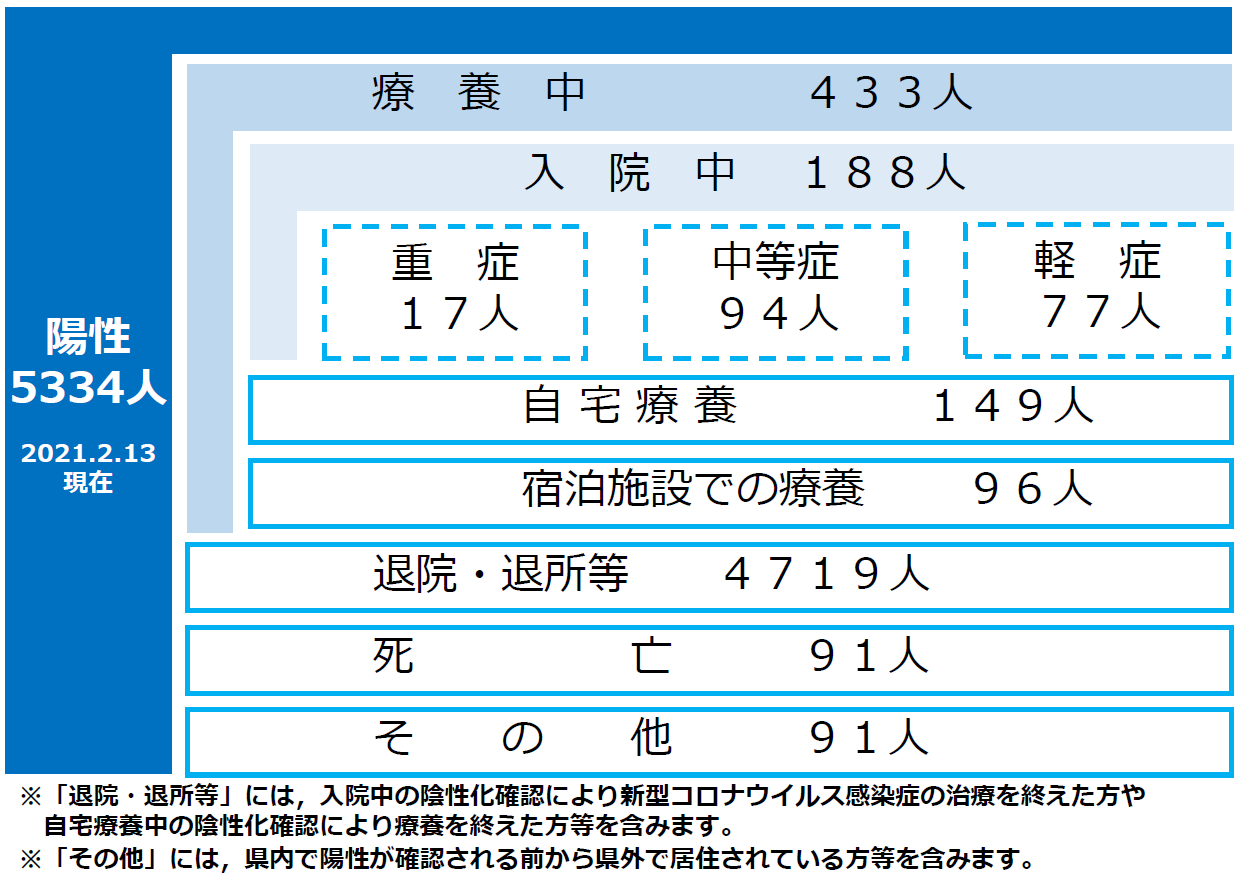

In [19]:
cv2_imshow(src)

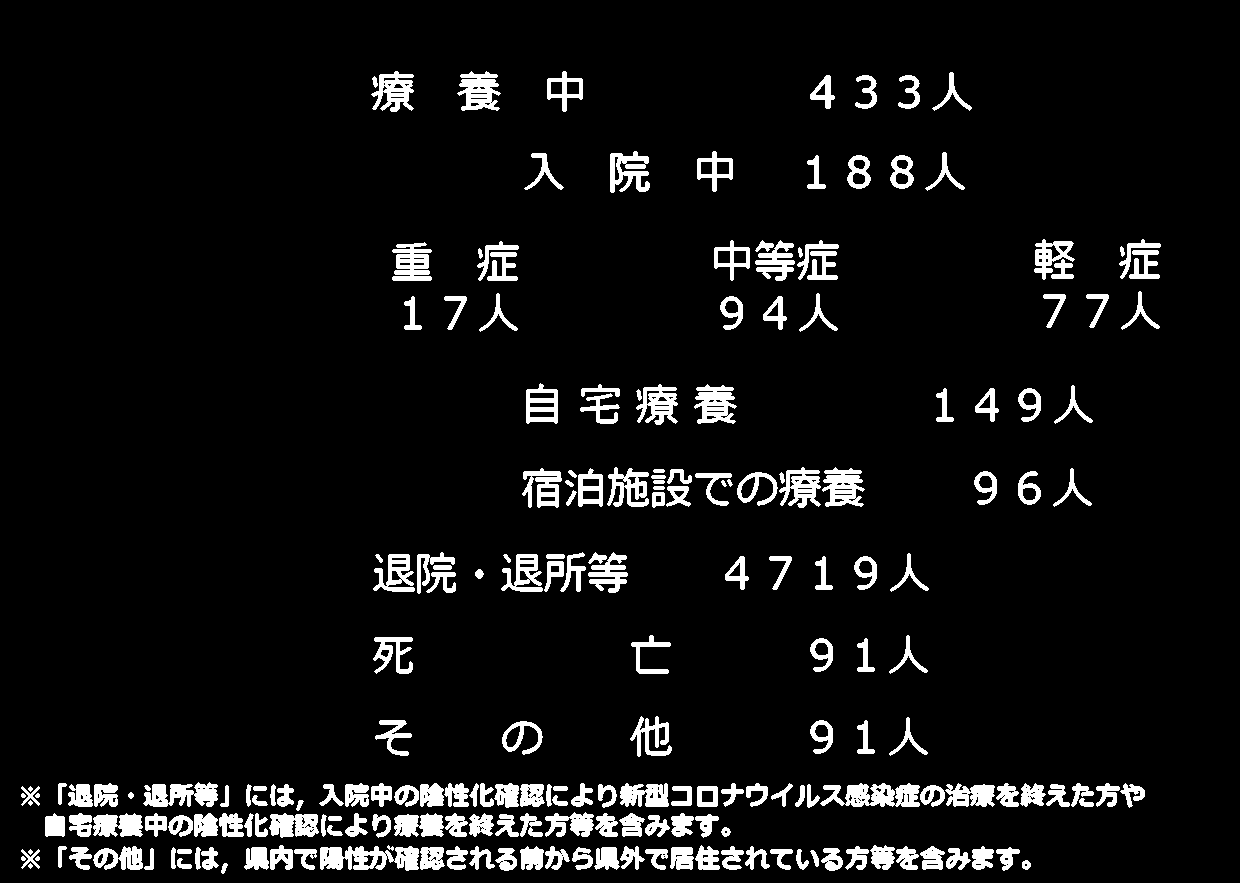

In [20]:
# 黒文字抽出
bin_img = cv2.inRange(src, (0, 0, 0), (100, 200, 200))

# 膨張
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
img = cv2.dilate(bin_img, kernel)

cv2_imshow(img)

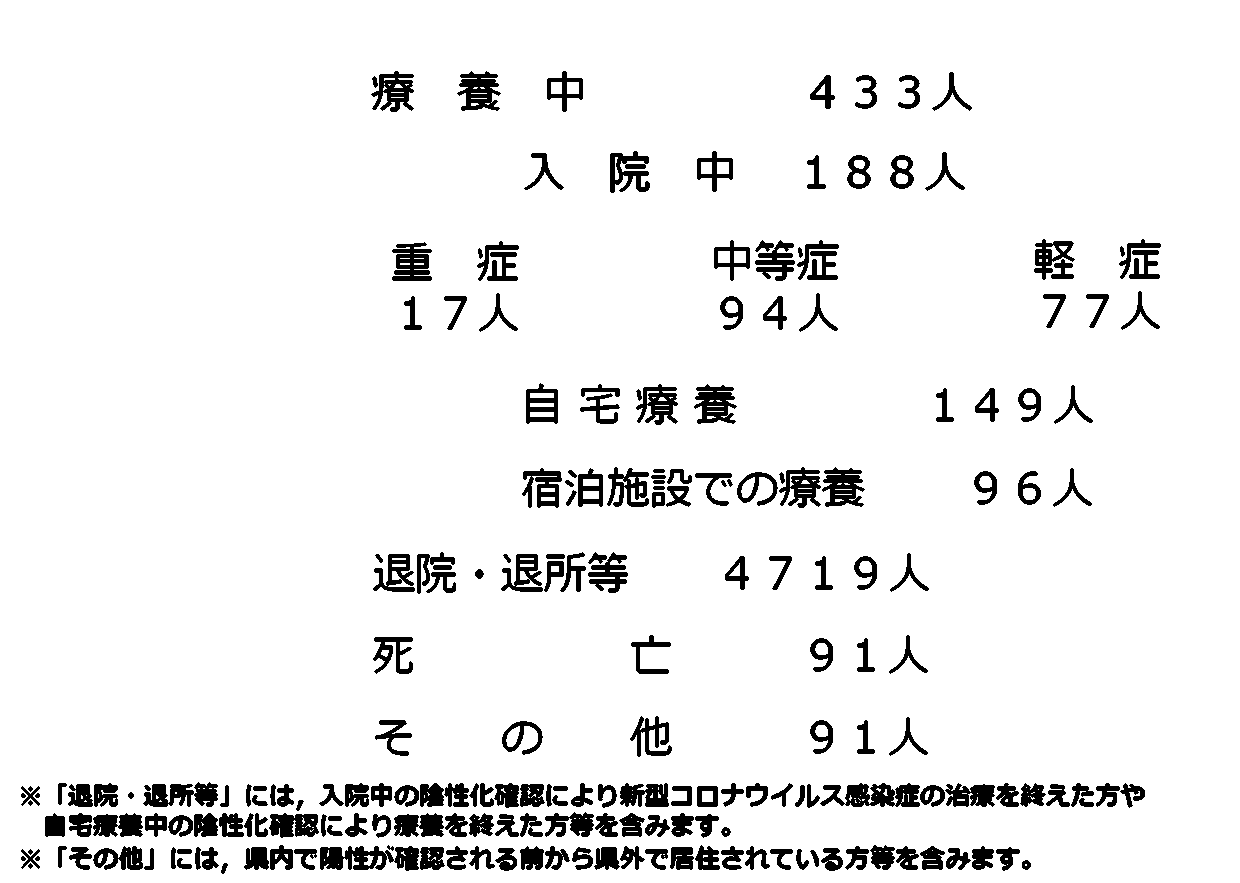

In [21]:
# 反転
dst = cv2.bitwise_not(img)
cv2_imshow(dst)

In [22]:
txt = (
    pytesseract.image_to_string(dst, lang="jpn", config="--psm 6")
    .strip()
    .replace(" ", "")
)
print(txt)

療末中433人
入院中188人
重症中等症軽症
17人94人77人
自宅療養149人
宿泊施設での療槍96人
退院・退所等4719人
死亡91人
その他91人
※「退院・退所等」には。入隊中の際性化確認により新型コロナウイルス感症の治療を終えた方や
自宅挟中の除性化確認により近級を終えた方等を含みます。
※「その他」には,。県内で陽性が確認される前から県外で居住されている方等を含みます。


In [23]:
data.extend(list(map(int, re.findall("(\d+)人", txt))))

In [24]:
data

[5334, 433, 188, 17, 94, 77, 149, 96, 4719, 91, 91]